# Image Partition using Diffusion maps

Using the Nyström method discribed in this paper: [Diffusion Maps Meet Nystrom](https://arxiv.org/abs/1802.08762).

Let $n$ be the number of pixels, and $sam$ be the number of sample points.

First, I construct the affinity matrix $K$ using Guassian kernel matrix with local scaling.
To compute the eigenvalues and eigenvectors of diffusion matrix, it is more convinient to compute the matrix $Q:= D^{-1}KD^{-1}$, where $D$ is a diagonal matrix with square root of row summation of $K$ on its diagonal.

By Nystrom method, for a positive definite matrix 
$Q = \left[\begin{matrix}
A & B^T  \\
B & C \\
\end{matrix}\right] $,
$$ Q \approx \left[\begin{matrix} A \\B \end{matrix}\right] A^{-1} \left[\begin{matrix} A & B^T \end{matrix}\right]$$

The paper I mentioned above uses the Cholesky decomposition 
$$Q \approx FF^{T} \text{, and define } F:= \left[\begin{matrix} A \\B \end{matrix}\right] A^{-1/2}.$$

By calculating the singular value decomposition of $F$, the eigenvalues and eigenvectors of diffusion matrix can be obtain by square root the singular values of $F$, and multiply $D^{-1}$ on the left side of singular vectors of $F$, respectively.



I only compute the first $sam$ columns of distance matrix from the beginning, however, the results are stunning. The diffusion map is constructed within seconds, the Nystrom method largely reduces the calculating demand. However, the K-means after diffusion that called to cluster data in the diffusion space become time consuming. The largest image I have calculated was images/view3.jpg , which has 2400*1500 pixels.

### Import libraries

In [1]:
%pylab inline
import cv2
from itertools import product
from scipy.spatial.distance import cdist
from scipy import sparse
from scipy.sparse.linalg import svds
from sklearn.cluster import KMeans

Populating the interactive namespace from numpy and matplotlib


### Load image

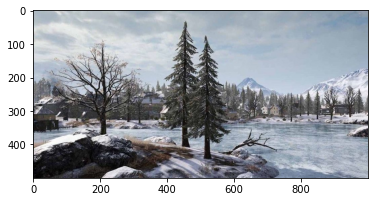

Size of figure:  500 * 1000


In [2]:
img = cv2.imread('images/view6.jpg')
img = img[:,:,::-1]

#normalize the RGB code
img = img/255

#show image
plt.imshow(img)
plt.show()

#size
x, y, z = img.shape
n = x*y
print('Size of figure: ', x,'*',y)

### Define functions

In [3]:
#image partition

def ip(datav):
    rand=calsam()       #randomly picked samples
    K=mk(rand)          #affinity matrix
    D, Dsmall=md(K)
    Q=mq(K, Dsmall, D)
    L, eigvec=eign(Q, D)   #eigenvalues and eigenvectors of diffusion matrix
    Y=my(L, eigvec)        #diffusion map
    print('Diffusiom map done.')
    
    labels=callabel(Y)    #using K-means to cluster data in the diffusion space
    print('Image partition done.')
    
    return labels

In [4]:
def calsam():
    return sort(permutation(n)[:sam])

In [5]:
def mk(rand):
    #distance matrix
    dist=vstack([cdist(datav[rand,:],datav[rand,:]), 
                 cdist(delete(datav,rand,axis=0),datav[rand,:])])
    
    #local scaling
    dist_sort=sort(dist, axis=0)    
    sigma=dist_sort[s+1,:]
    sigma[argwhere(sigma==0)]=10000
    sigmasmall=diag(1/sigma)
    
    dist_sort=sort(dist, axis=1)
    sigma=hstack([sigma,dist_sort[sam:,s+1]])
    sigma[argwhere(sigma==0)]=10000
    sigma=sparse.dia_matrix((1/sigma,0), shape=(n,n))
    
    return exp( -sigma.dot(dist).dot(sigmasmall) )    #Affinity matrix

In [6]:
def md(K):
    Dsmall=diag(1/sqrt(sum(K[:sam,:sam],axis=1)))
    D=sparse.dia_matrix((1/sqrt(sum(K,axis=1)),0), shape=(n,n))
    
    return D, Dsmall

In [7]:
def mq(K, Dsmall, D):
    return D.dot(K).dot(Dsmall)

In [8]:
def eign(Q, D):
    uu, ul, uv=svd(Q[:sam,:])
    ul=diag(ul**(-1/2))
    Asi=uu.dot(ul).dot(uv)
    
    F=Q.dot(Asi)

    U, L, V=svds(F, dim)

    L=diag(sqrt(L[::-1]))
    eigvec=D.dot(U[:,::-1])
    
    return L, eigvec

In [9]:
def my(L, eigvec):
    return eigvec.dot(L)

In [10]:
def callabel(Y):
    kmeans=KMeans(clusters)
    kmeans=kmeans.fit(Y)
    labels=array(kmeans.predict(Y)).reshape(n,1)
    
    return labels

### Set parameters

In [14]:
sam=10        #number of sample points to compute
s=7           #local scaling parameter
dim=3         #embedding dimension
clusters=20   #reduce image into how many colors

### Calculate the diffusion map and labeling

In [15]:
datav=img.reshape(n, z)
labels=ip(datav)

Diffusiom map done.
Image partition done.


### Display result

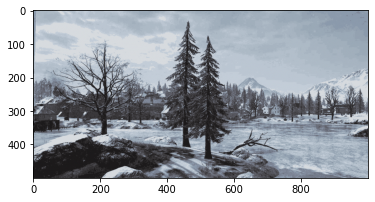

Using 10 sample points.
Using 20 colors.


In [16]:
#calculate colors
colorrgb=[]
for i,j in product(range(clusters), range(z)):
    colorrgb.append(percentile( datav[argwhere(labels==i)[:,0],j],50 ))
    
    
#show image
imc=zeros((n,z))
for i in range(clusters): imc[argwhere(labels==i)]=colorrgb[3*i:3*i+3]
imc = imc.reshape(x,y,z)

plt.imshow(imc)
plt.show()

print('Using', sam, 'sample points.')
print('Using', clusters, 'colors.')

#matplotlib.image.imsave('flower_11sam10color.jpg', imc)